In [1]:
import numpy as np, matplotlib.pyplot as plt, cv2
import cvflow as cf
import laneFindingPipeline
from jupyterTools import src
%matplotlib inline

In [2]:
def getPropertySource(op, propertyName='value'):
    """Unpack an @property and return a pretty-printing source-code object.
    
    from stackoverflow.com/questions/1360721
    """
    return src(op.__class__.mro()[0].__dict__[propertyName].fget.__closure__[0].cell_contents)

In [3]:
allFrames = laneFindingPipeline.utils.loadFrames(maxFrames=32)

In [4]:
frame = allFrames['project'][-1]

## Development of a pipeline for identifying lane-marking pixels

### `cvflow` for visualizing OpenCV pipelines
I fell down a rabbithole on this project implementing a computational graph library for assembling my OpenCV pipelines. This was inspired (obviously) by TensorFlow. Though here I use such an approach merely for convenience of introspection rather than for allowing for code generation, I could see that being an alternate use. Towards the end of this report, I'll list this and a few other possible future improvements to this library.

The basic object in cvflow is the `Op` (aka "node"), which wraps some operation, such as a simple `Add` of two or more arrays, or more relevantly, something like `cv2.cvtColor`. Crucially, `Op` objects contain a `parents` list, which they use directly in their wrapped operation, a `object.value` property which returns the result of this operation, and a `children` list, each of whom have this object as a parent and make use of its `object.value` property.

These nodes form a directed acyclic graph (DAG) (though I do no explict test for acyclicity, I rely on it throughout to avoid `RecursionError`s), so the `object.value` properties are cached on their first evaluation so that they are not recomputed for use by multiple children. A special `Op` subclass called `BaseImage` (with subclasses `ColorImage` and `MonoImage` acting as further offenses in the ongoing violation of [YAGNI](https://en.wikipedia.org/wiki/You_aren%27t_gonna_need_it) that is this library) calls `self.invalidateCache` on the setter of the `self.value` property, which recursively calls itself on the children of the `BaseImage`. 

In [5]:
op = cf.Op()
src(op.invalidateCache)

Thus, with one such node serving as the primary user-interactive root node for the digraph, setting its `.value` results in clearing the cached values for all descendants. I have not implemented this cache-clearing cascade behavior for any other types of root nodes (e.g., `Constant` nodes such as kernel matrices), since I figured I had to draw the line somewhere on this project. I also have not tested this approach with pipelines containing multiple `BaseImage` input nodes, but the behavior should work for those as well--only nodes which are direct descendants of the currently altered node will have their cache cleared, which is as it should be. Clearing the cache for a node twice is harmless.

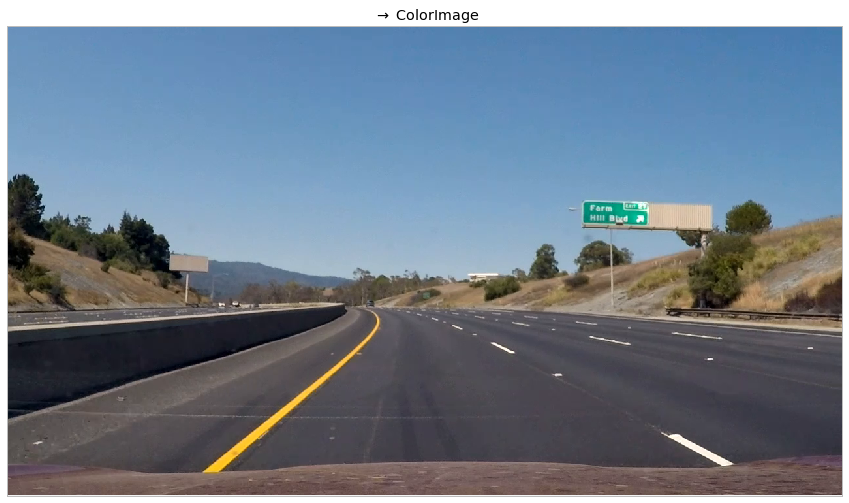

In [6]:
colorImage = cf.ColorImage()
colorImage.value = frame
colorImage.showValue();

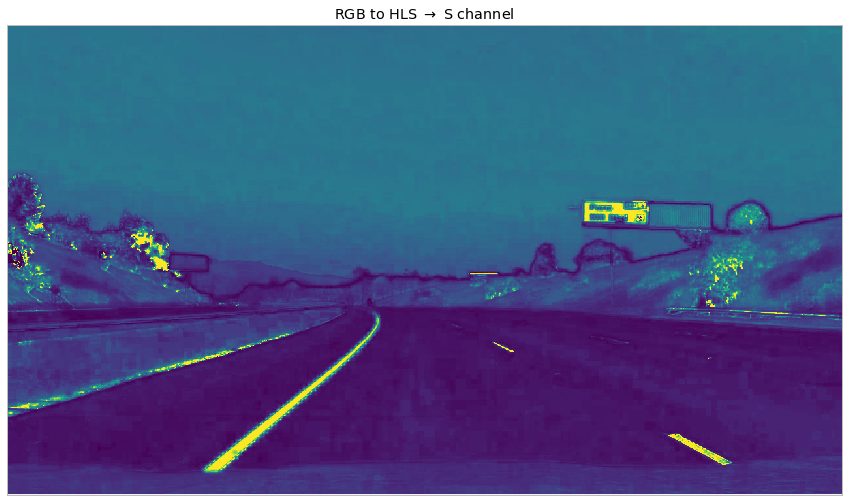

In [7]:
hls = cf.CvtColor(colorImage, cv2.COLOR_RGB2HLS)
s = cf.ColorSplit(hls, 2)
s.showValue();

Some operator overloading is also implemented.

/home/tsbertalan/.virtualenvs/carnd/lib/python3.5/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in log10
  if sys.path[0] == '':


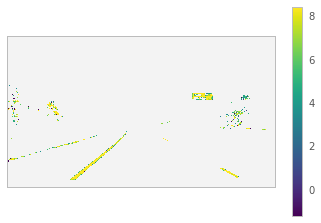

In [8]:
# Re-implement the `cf.Expand` op,
# for emphasizing outliers in a nonlinear way.
x = cf.AsType(s, 'float64')
centered = x - x.max() / 2
neg = centered < 0
pos = centered >= 0
widenedFlippedSign = centered ** 4
expanded = -abs(widenedFlippedSign & neg) + (widenedFlippedSign & pos)

mat = expanded.value
fig, ax = plt.subplots()
im = ax.imshow(np.log10(mat))
ax.set_xticks([]); ax.set_yticks([])
fig.colorbar(im);

A second useful effect of this DAG structure is that requesting `object.value` on some leaf node propagates the execution of wrapped operations only up through direct ancestor nodes, without wastefully computing the results of side branches. This allows for the addition of speculative chains of operations that do not lead to the final result, for exploration purposes without slowing down the main execution, though there would be no reason to keep these in production. Analogously to the use of preprocessor directives in compiled languages, full-DAG operations take place only at instantiation time (and for some plotting and introspection purposes not necessary for executing the graph), not at execution.

Subclassing `Op` is the `MultistepOp` class, which adds additional logic supporting nodes that wrap subgraphs of other nodes in convenient bundles. This became a primary motivation for the (perhaps inadvisable) creation of this library when I noticed that certain motifs of repeated OpenCV operations were useful in my pipeline. 

Of course, such reused multi-step operations in OpenCV could be accomplished just fine through normal functions, but it would be difficult to introspect their structure and intermediate stages. This was the other major motivation for this library. Upon request, any node in the digraph can assemble an object representing the entire digraph in a convenient form (a combination of networkx and graphviz digraph objects). Courtesy of graphviz, this representation can be displayed in a Jupyter notebook, or written to various file formats.

We'll now use this to depict the DAG we've just constructed.

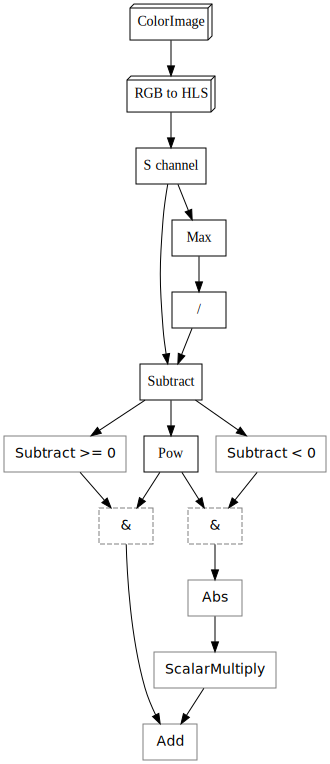

In [9]:
expanded.draw(addKey=False)

The key used for these diagrams is always as follows:

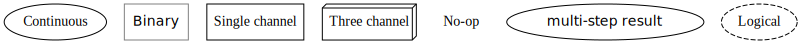

In [10]:
label, gv, nx = cf.misc.makeKeySubgraph()
gv

## Preprocessing pipeline

### A simple pipeline

With significant effort invested to create this library, we can now use it to prototype some image pre-processing pipelines.

HBox(children=(IntProgress(value=0, description='cal. undistort: ', max=20), HTML(value='')))

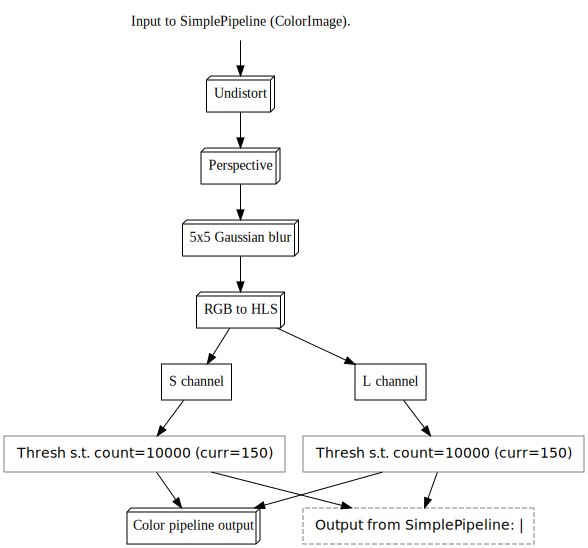

In [11]:
pipeline = cf.SimplePipeline()
pipeline.getSubgraph()

This pipeline is fairly simple--we use the saturation channel to detect the yellow left line, and the lightness channel to detect the white right line. It works for most of the project video.

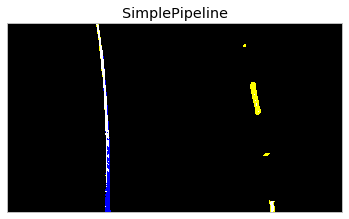

In [12]:
linePixels = pipeline(frame)
color = pipeline.colorOutput.value
laneFindingPipeline.utils.show(color, title=pipeline);

To find only relevant pixels in each channel, I use the complicated (but not `MultistepOp`) `CountSeekingThreshold` op.

In [13]:
thresh = pipeline.getByKind(cf.CountSeekingThreshold)[0]
getPropertySource(thresh)

Basically, we set a `goalCount` of around 10000 pixels, then, rely on the fact that the number of thresholded pixels is monotonic in the current threshold to do a bifurcation search for the threshold that brings us within `countTol` of the goal.

It occurs to me that such a dynamic thresholding might already be implemented in OpenCV, but, since other Sobel-only methods actually proved more useful than thresholding of any kind, I didn't pursue this further.

The problem with this or a fixed-threshold approach is that occasionally large splotches of brightness would come along in the monitored channel. For any reasonable `goalCount`, these splotches would quickly drive the threshold up to the maximum of 255, resulting in a mask empty of identified pixels.

### A more complicated preprocessing

The Sobel x channel

# Future work
* Use a predictive model for the evolution of the lane lines--e.g., fit a polynomial in time.